# How to run custom variational algorithms
**Running variational algorithms with the `iterate` function**

Fire Opal's `iterate` function is optimized for [submitting multiple jobs](https://docs.q-ctrl.com/fire-opal/topics/submitting-multiple-jobs), which makes it an excellent tool for running variational quantum algorithms (VQAs). Compared to the `execute` function, which should be used for single-job submission, the `iterate` function optimizes preprocessing and device queuing time when jobs are submitted in immediate succession.

Variational quantum algorithms involve iteratively adjusting the parameters of a parameterized quantum circuit to optimize an objective function, ultimately finding approximate solutions to optimization problems or simulating quantum systems.

In this guide, you will learn how to use Fire Opal's `iterate` feature for variational quantum algorithms.

## Summary workflow
The following steps describe the general workflow for running variational quantum algorithms.

### 1. Prepare the variational ansatz
Design a [parameterized quantum circuit (PQC)](https://docs.q-ctrl.com/fire-opal/user-guides/how-to-run-parameterized-quantum-circuits) that represents the problem. This circuit typically includes variational parameters that can be adjusted to minimize some cost function.

### 2. Define the objective function
Define a cost function that quantifies how well the quantum circuit solves the problem. This cost function typically depends on the outcomes of measurements performed on the quantum circuit.

### 3. Run the optimization loop using `iterate`
Initialize the parameters of the PQC and execute it on the quantum hardware. Calculate the cost function and use classical optimization methods to continuously adjust the parameters until reaching desired convergence criteria.

### 4. Evaluate results
Analyze the final solution obtained from the quantum circuit execution. 

## Example: Running the Variational Quantum Eigensolver (VQE) algorithm with `iterate`
In this example, the `iterate` function is used to run a sample 3-qubit VQE algorithm that obtains the lowest eigenvalue of the observable $\hat{O} = Z_0Z_1Z_2$. This example is used as a demonstration, and the `iterate` function can easily be applied to other VQAs using similar patterns.

There are numerous tutorials available online that dive further into the theory and structure of building a VQE algorithm, such as this [demonstration by Pennylane](https://pennylane.ai/qml/demos/tutorial_vqe/).

### 1. Import libraries and set up credentials

In [ ]:
import fireopal as fo
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit import qasm3
import numpy as np
from scipy.optimize import minimize

In this example, the iterative workload is run on IBM Quantum. The following code builds a credentials object using credentials that can be obtained on the [IBM Quantum Platform](http://quantum.ibm.com) dashboard.

In [ ]:
# These are the properties for the publicly available provider for IBM backends
# If you have access to a private provider and wish to use it, replace these values
hub = "ibm-q"
group = "open"
project = "main"
token = "YOUR_IBM_TOKEN"
credentials = fo.credentials.make_credentials_for_ibmq(
    token=token, hub=hub, group=group, project=project
)

### 2. Prepare the variational ansatz
This example uses parameterized quantum circuits, which are supported in both Fire Opal's `iterate` and `execute` functions. PQCs must be converted to OpenQASM 3.0 for submission to Fire Opal.

In [5]:
# Prepare the initial state, specifically flipping the states of qubits 0 and 2 to |1> using X-gates
initial_state = QuantumCircuit(3)
initial_state.x(0)
initial_state.x(2)
initial_state.barrier()

# Define the variational ansatz using the TwoLocal circuit template
qc = TwoLocal(
    num_qubits=3,
    rotation_blocks=["ry"],
    entanglement_blocks="cx",
    entanglement="full",
    initial_state=initial_state,
    reps=1,
    flatten=True,
    insert_barriers=True,
)
qc.barrier()

# Rotate qubits for a Z-basis measurement
# No rotation needed for qubit 0 as it aligns with Pauli Z
qc.h(1)  # Apply Hadamard gate to qubit 1 to measure in X basis
qc.h(2)  # Apply Hadamard gate to qubit 2 to measure in X basis

qc.measure_all()
qc.draw("mpl")

# Convert to OpenQASM3
qasm_circ = qasm3.dumps(qc)

### 3. Set initial parameters

In [6]:
# Set up initial parameters or default to zeros
init_params = np.zeros(len(qc.parameters))

### 4. Define the objective function
When performing iterative optimization, the cost function determines the objective to minimize. In VQE, the objective is to minimize the expectation value of the Hamiltonian to find the ground state energy of the quantum system. `iterate` is used to run the parameterized circuit with the updated parameters and return values used to compute the expectation value.

In [11]:
# Set shot count and define backend
# To get a list of supported backends, run fo.show_supported_devices(credentials)
shot_count = 2048
backend_name = "desired_backend"

In [12]:
# Store the history of calculated expectation values
expectation_value_history = []


def convert_counts_to_probability_list(counts, nqubits):
    """
    Transforms a dictionary of measured counts into a list of probabilities in the computational basis.
    """
    probs = []
    for key in range(2**nqubits):
        binary_key = format(key, "b").zfill(nqubits)
        probs.append(counts.get(binary_key, 0))
    return probs


def objective_function(parameters):
    """
    Calculates the cost based on the quantum circuit's outcome.
    Maps numerical parameters to the circuit parameters, runs the circuit, and computes the expectation value.
    """
    # Map the parameters to the circuit parameters
    parameters_dict = {param.name: val for param, val in zip(qc.parameters, parameters)}

    job = fo.iterate(
        circuits=[qasm_circ],
        shot_count=shot_count,
        credentials=credentials,
        backend_name=backend_name,
        parameters=[parameters_dict],
    )
    counts = job.result()["results"][0]
    measured_probs = convert_counts_to_probability_list(counts, qc.num_qubits)

    # Calculate the expectation value based on measured probabilities
    expectation_value = calculate_expectation(measured_probs)

    # Save the intermediate cost values without additional calls to this objective function
    global expectation_value_history
    expectation_value_history.append(expectation_value)

    return expectation_value


# Define the observable eigenvalues for post-processing the probability distributions
eigenvalues_ZIX = np.kron(np.kron([1, -1], [1, 1]), [1, -1])
eigenvalues_ZXI = np.kron(np.kron([1, -1], [1, -1]), [1, 1])
eigenvalues_IXX = np.kron(np.kron([1, 1], [1, -1]), [1, -1])


def calculate_expectation(measured_probs):
    """
    Computes expectation values for given Pauli strings using the measured probabilities.
    """
    exp_val_ZIX = np.dot(eigenvalues_ZIX, measured_probs)
    exp_val_ZXI = np.dot(eigenvalues_ZXI, measured_probs)
    exp_val_IXX = np.dot(eigenvalues_IXX, measured_probs)

    # Combine the expectation values according to the Hamiltonian coefficients
    expectation = 1 * exp_val_ZIX - 0.5 * exp_val_ZXI + 0.5 * exp_val_IXX
    return expectation

### 5. Run the optimization loop using `iterate`
You can choose a classical optimizer to minimize the cost function. In this case, the COBYLA solver from SciPy is applied through the minimize function. Once the `minimize` routine has completed, call `stop_iterate` to close the session on IBM Quantum systems in order to reduce total runtime.

In [ ]:
# Set options to limit max iterations
options = {"maxiter": 30, "rhobeg": 0.5, "disp": True}

# Minimize the objective function using COBYLA method
opt_result = minimize(
    objective_function, init_params, method="COBYLA", tol=0.01, options=options
)

# Stop iterating once convergence is reached
fireopal.stop_iterate(credentials, backend_name)

### 6. Evaluate results
Once the algorithm has converged or reached the maximum number of iterations, you can evaluate the final expectation value and the history across each iteration. You can visually confirm that the expectation value decreases and converges to the ideal solution.

In [ ]:
final_expectation_value = opt_result["fun"]
print("\n" f"Final value of the ground-state energy = {final_expectation_value}")

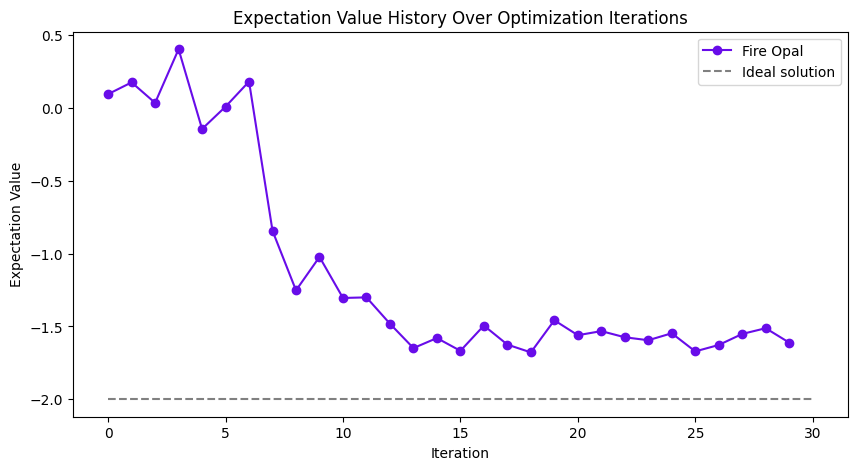

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(
    expectation_value_history,
    marker="o",
    linestyle="-",
    color="#680CE9",
    label="Fire Opal",
)
plt.title("Expectation Value History Over Optimization Iterations")
plt.xlabel("Iteration")
plt.ylabel("Expectation Value")
plt.hlines(-2.0, 0, 30, linestyles="dashed", color="grey", label="Ideal solution")
plt.legend()
plt.show()